In [2]:
import pandas as pd; import sys
import matplotlib.pyplot as plt
import numpy as np
import datetime


from IPython.display import display
pd.options.display.max_columns = None
pd.options.display.max_rows = 1000
pd.options.display.max_colwidth = 100
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [17]:
from statsmodels.stats.weightstats import ztest, ttest_ind
from scipy import stats
from scipy.stats import ttest_ind as ttest_ind_from_scipy
import seaborn as sns
from statsmodels.stats.power import tt_ind_solve_power
from hashlib import sha256
from tqdm import tqdm
from scipy.stats import kstest
import matplotlib

### Запуск теста

При запуске теста фиксируется **слой** (hash_layer) - в нем происходит разбивка пользователей на ветки.  
У каждого слоя своя соль = хеш, который однозначно мапит клиентов на сплиты.  
Непересекающиеся экперименты необходимо проводить в одном слое в разных сплитах (с общим контролем).  
Пересекающиеся по функционалу эксперименты можно проводить в разных слоях поверх друг друга.  
Эффект будет усредняться. Правда может быть несколько уменьшена сравнительная величина эффектов.  

In [5]:
import string
# генерация произвольной соли для слоя эксперимента
def _generate_salt(seed=None):
    """Рандомная соль эксперимента"""
    np.random.seed(seed=seed)
    return ''.join(np.random.choice(list(string.ascii_letters), size=10))
salt = _generate_salt()
salt

'zZdprsvkIs'

In [8]:
# Пример выдачи сплита (-> номера ветки) по идентификатору юзера на основе заданной соли слоя
def get_split(identifier, salt, n_splits, AB_HASH_LENGTH = 15):
    id_hash = sha256((str(identifier) + salt).encode('utf-8')).hexdigest()
    split = int(id_hash[:AB_HASH_LENGTH], base=16) % n_splits
    return split
identifier_1, identifier_2 = 1, 2
get_split(identifier_1, salt, 10), get_split(identifier_2, salt, 10)

(8, 1)

### Валидация метрик

In [23]:
import imp
import help_tools
imp.reload(help_tools)
from help_tools import mean_ttest, init_matplot

<module 'help_tools' from '/Users/nikitagavrev/main/analytics_tools/help_tools.py'>

In [ ]:
# todo теория 

In [18]:
def validation(metric_values, 
               iterations=10**3,
               figsize_xy=(15, 5),
               alpha_range=np.arange(0, 0.11, 0.01),
               bins=50,
               stat_test_func = mean_ttest):
    """Проверка """
    # семплирование и АА-тесты
    seed_list = np.random.randint(np.iinfo(np.int32).max, size=iterations)
    p_value_list = []
    metric_values = np.array(metric_values)
    for seed in tqdm(seed_list):
        np.random.seed(seed=seed)
        mask = np.random.randint(0, 2, size=len(metric_values)) > 0
        data_a = metric_values[mask]; data_b = metric_values[~mask]
        # здесь может быть любая необхоимая функция
        p_value, _, _ = mean_ttest(data_b, data_a)
        p_value_list.append(p_value)
    # проверяем равномерность семплирования p_value (признак прохождения валидации)
    _, p_val_uniform = kstest(p_value_list, 'uniform', args=(0, 1), alternative='two-sided')
    validation_res = {'is_uniform': p_val_uniform > 0.05, 'p_val_uniform': p_val_uniform}
    p_value_list = np.array(p_value_list)
    p_value_list_res = p_value_list.copy()
    # Визуализация - гистограмма
    fig, list_ax = init_matplot(figsize_xy=figsize_xy, subplot_grid=(1, 2))
    plt.sca(list_ax[0])
    pd.DataFrame({'p_value' : p_value_list}).p_value.hist(bins=bins)
    q = round(100 * len(p_value_list[p_value_list < 0.05]) / len(p_value_list), 1)
    r = len(p_value_list) / bins
    plt.plot([0,1], [r-2*np.sqrt(r), r-2*np.sqrt(r)])
    plt.plot([0,1], [r+2*np.sqrt(r), r+2*np.sqrt(r)])
    title = f'Равномерность распределения p_value \n на гистограмме -> {len(p_value_list)} АА-тестов'
    plt.xlabel('p_value'); plt.ylabel('Кол-во A/A тестов'); plt.title(title)
    # Визуализация - линейный график
    plt.sca(list_ax[1])
    val_list = [len(p_value_list[p_value_list < alpha]) / len(p_value_list) for alpha in alpha_range]
    plt.plot(alpha_range, val_list, 'o-')
    plt.plot(alpha_range, alpha_range, '--g')
    title = f'Зависимость доли ложных прокрасов от ошибки первого рода теста \n {validation_res}'
    plt.title(title); plt.ylabel('alpha_real'); plt.xlabel('alpha_test')
    plt.xticks(alpha_range); plt.yticks(alpha_range); plt.grid(); plt.tight_layout()
    return p_value_list_res

100%|██████████| 10000/10000 [00:02<00:00, 4811.12it/s]


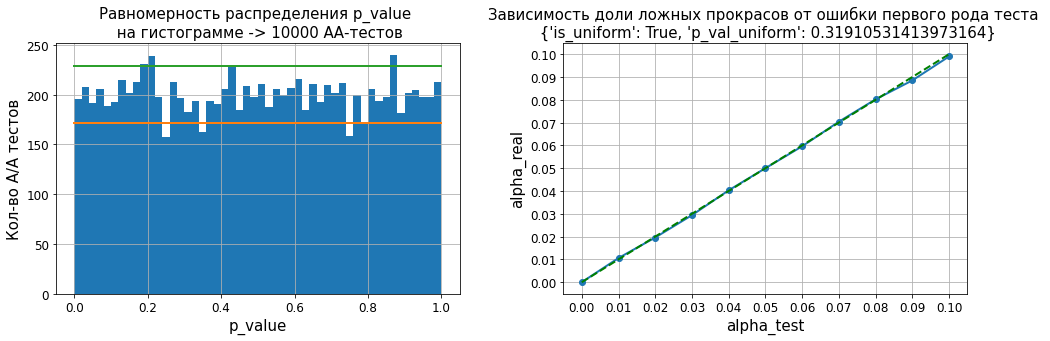

In [27]:
# нормально распределенная метрика
metric_values = stats.norm.rvs(scale=1, loc=1, size=1000)
_ = validation(metric_values, iterations=10**4);

Если в метрике присутствуют выбросы, то по ЦПТ ее **средневыборочное** не распределено нормально.  
В этих условиях классические критерии (T-test) не работают корректно.  
Дисперсия средневыборочного резко возрастает из за выбросов.  
При малых alpha применяемого теста (низкая ошибка первого рода) тест почти всегда дает серый результат (не дает прокрасов).  
С ростом alpha (снижается точность теста) - тест наоборот дает много ложных прокрасов из за случайного влияния выброса на А/А.  

100%|██████████| 10000/10000 [00:02<00:00, 4826.98it/s]


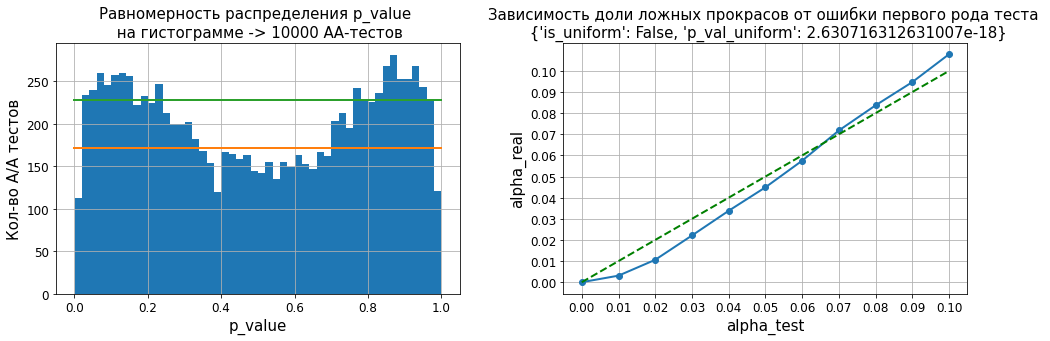

In [33]:
# метрика с одиночным выбросом
metric_values = np.append(stats.norm.rvs(scale=1, loc=1, size=1000), np.array([40])) 
_ = validation(metric_values, iterations=10**4);

### Объем выборок

**MDE**  
alpha - ошибка 1го рода - вероятность ложного срабатывания теста  
betta - ошибка 2го рода - вероятность не-срабатывания теста при реальном различии  
power = 1-betta - мощность теста. При фикс alpha чем выше - тем лучше.  

Зная ошибки и параметры контрольной выборки в предположении можно для  
минимального ожидаемого эффекта (minimal effect size) оценить размер выборок.  

Если std_exp ~ std_control:
effect_size = mean_delta / std_control  
В общем случае:
effect_size = mean_delta / std_c  
TODO - разобраться.   


In [ ]:
# Поиск MDE по сделанным измерениям
# заданы параметры метрики в контрольной выборке:
control_loc = 10
control = stats.norm.rvs(scale=1, loc=control_loc, size=1000)
# для фиксированных ошибок 1го (alpha) и 2го (1-power) рода определяем какое изменение метрики (минимальное) сможем задетектировать
power = 0.8 # допускаем серое, когда зеленое в 20% случаев
effect_size = tt_ind_solve_power(nobs1=len(control), alpha=0.05, power=power, ratio=1, alternative='two-sided')
exp_mean_thr = control_loc + effect_size * np.std(control)
# проверяем статистическую нагрузку на тест:
stat = []
for _ in range(5000):
    control = stats.norm.rvs(scale=1, loc=control_loc, size=1000)
    exp = stats.norm.rvs(scale=1, loc=exp_mean_thr, size=1000)
    a,b = mean_diff_confint(control, exp)
    if a>0:
        stat.append(1)
    else:
        stat.append(0)
np.mean(stat) # доля прокрасов по доверительному интервалу

In [ ]:
control_loc = 10
control = stats.norm.rvs(scale=1, loc=control_loc, size=1000)
mean_delta = 0.05 # минимальная точность измерения

effect_size = mean_delta / np.std(control)
nobs1 = tt_ind_solve_power(effect_size=effect_size, alpha=0.05, power=0.8, ratio=1, alternative='two-sided')
print('N_control/exp', nobs1)
# nobs1 - сколько семплов на ветку для различимости заданного эффекта с фикс ошибками
# проверяем статистическую нагрузку на тест:
stat = []
for _ in range(5000):
    control = stats.norm.rvs(scale=1, loc=control_loc, size=int(nobs1))
    exp = stats.norm.rvs(scale=1, loc=control_loc+mean_delta, size=int(nobs1))
    a,b = mean_diff_confint(control, exp)
    if a>0:
        stat.append(1)
    else:
        stat.append(0)
np.mean(stat) # доля прокрасов по доверительному интервалу

In [ ]:
def get_n_sample(metric_values,
                 delta_list = range(1, 10, 1), # относительное изменение метрики 
                 alpha = 0.05,
                 power=0.8,
                 ratio=1 # ratio = n_experiment / n_control
                ):
    """Какое кол-во юзеров потребуется для трекинга разного относительного изменения метрики"""
    df_stat = pd.DataFrame(None, columns=['metric_relative_change_%', 'n_exp_users']); j=0
    delta_list = np.array(delta_list) 
    metric_mean, metric_std = np.mean(metric_values), np.std(metric_values)
    for c in delta_list:
        effect_size = (metric_mean * c / 100) / metric_std
        n_total = (1+ratio) * tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, ratio=ratio, alternative='two-sided')
        df_stat.loc[j, :] = c, n_total; j+=1
    return df_stat

### Сбалансированность и репрезентативность выборок

Цель теста - сравнение показателей для двух генеральных совокупностей (A/B)  
Каждая совокупность семплируется - при этом необходимо контролировать правило доступа каждого семпла г.с. в выборку.  
Например, если клиенты не доходят до тестируемого экрана - их можно не включать в выборку.  
Остальные клиенты должны иметь равную возможность попадать в выборку!  
При этом случайность семплирования должна быть как по популяции, так и по времени.  
**Репрезентативность** - обобщаемость используемой выборки на всю генеральную совокупность.  
При нестационарном поведении генеральной совокупности во времени необходимо случайно семплировать выборку для теста также по времени.  
**Сбалансированность** - правила по ограничению попадания семплов из г.с. в выборку в тесте/контроле должны быть **одинаковые**  

In [ ]:
# todo chi2 - тест

### Множественное сравнение

In [ ]:
# Поправка Бонферони?

### Бакетный анализ / децильный анализ

In [ ]:
# todo
# https://www.youtube.com/watch?v=p_5YzShN4sg
# децильное распределение val_list1, val_list2 на основании бутстрапа
# N-й дециль -> доверительный интервал , контрольное значение 

### Последовательный анализ

### Ресемплинг методы

In [ ]:
# бутстрап, пермутации и пуассоновский бутстрап


### Методы увеличения чувствительности